# Julia Serial Connection
## LibSerialPort

In [1]:
using Pkg
Pkg.add("FFTW")
using PyPlot

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [4]:
using LibSerialPort
list_ports() 

/dev/ttyACM3
	Description:	USB Serial - 5870570
	Transport type:	SP_TRANSPORT_USB


## Open Serial Connection

In [5]:
sp=open("/dev/ttyACM3",9600) 

SerialPort(Ptr{LibSerialPort.SPPort} @0x0000000005a52a80, false, true)

In [ ]:
while true
    write(sp,"s")
    sleep(0.05)
end    

In [101]:
close(sp)

SerialPort(Ptr{LibSerialPort.SPPort} @0x00000000028ec660, false, false)

## Serial Commands
- write(sp,"b")
- bytesavailable(sp)
- read(sp,UInt8)   




## Echo Server Test

In [ ]:
# Clear buffer
while (bytesavailable(sp)>0)
    read(sp)
end

NStart=0
NEnd=255


for n = NStart:NEnd
    #a = string("",n)
    #println("writing ",UInt8(n))
    write(sp,UInt8(n))
    sleep(0.001)
end
sleep(0.1)

BytesWritten=NEnd-NStart+1

println("Bytes written ",BytesWritten)

BytesAvailable=bytesavailable(sp)
println("Bytes available:",BytesAvailable)

x=zeros(UInt8,BytesAvailable)

for n = 1:BytesAvailable
    x[n]=read(sp,UInt8)
    println(Int(x[n]))
end
    

## Sampling Test

In [29]:
# Clear buffer
while (bytesavailable(sp)>0)
    read(sp,UInt8)
end

a = "" # Keep bytes as a string
i = 0
b=""

# Send command
BytesWritten=1
Command = "b"
write(sp,Command) # See code for command meanings
println("Command Sent ",Command)

while bytesavailable(sp) < 1
    continue # wait for a response    
end  

while true
    if bytesavailable(sp) < 1
        sleep(0.050) # Wait and check again
        if bytesavailable(sp) < 1
            println("Finished Reading")
            break
        end
    end
     b = read(sp,UInt8) # Using read() is much slower due to extra delays
#     a = string(a,b)
    i += 1    
end

println("Sample complete")
println("Bytes recieved: ",i)



# println("Bytes written ",BytesWritten)

# BytesAvailable=bytesavailable(sp)
# println("Bytes available:",BytesAvailable)

# x=zeros(UInt8,BytesAvailable)

# for n = 1:BytesAvailable
#     x[n]=read(sp,UInt8)
#     #println(Int(x[n]))
# end


Command Sent b
Finished Reading
Sample complete
Bytes recieved: 40000


## Working Sampling Test

In [3]:
# set number of samples
S = 20000

# Clear buffer
while (bytesavailable(sp)>0)
    read(sp,UInt8)
end

a = "" # Keep bytes as a string
i = 1
b=""

x=zeros(UInt8,S*2)

# Send command
BytesWritten=1
Command = "b"
write(sp,Command) # See code for command meanings
println("Command Sent ",Command)

while bytesavailable(sp) < 1
    continue # wait for a response    
end  

while true
    if bytesavailable(sp) < 1
        sleep(0.050) # Wait and check again
        if bytesavailable(sp) < 1
            println("Finished Reading")
            break
        end
    end
    x[i]=read(sp,UInt8)
#      b = read(sp,UInt8) # Using read() is much slower due to extra delays
#     a = string(a,b)
    i += 1    
end

println("Sample complete")
RecievedBytes=i-1
println("Bytes recieved: ",RecievedBytes)

x_rx=zeros(UInt16,S)
i = 1
for n = 1:S
    x_rx[n]=(UInt16(x[i])<<8 | UInt16(x[i+1]))
    i+=2
end

time = read(sp,UInt8)
figure()
plot(x_rx[1:50])
using FFTW
X = fft(x_rx)
figure()
plot(fftshift(abs.(X)),".-")

UndefVarError: UndefVarError: sp not defined

In [301]:
write(sp,"t")
sleep(0.1)
# timeMicro = read(sp,Int)
timeMicro = parse(Int,readline(sp) )
timeMilli = timeMicro*10^-3
time = timeMicro*10^-6
sampleRate = S/(time)
println("Time to sample " ,timeMilli, "(ms)")
println("Sample rate " ,sampleRate)

Time to sample 138.04400000000004(ms)
Sample rate 144881.3421807539


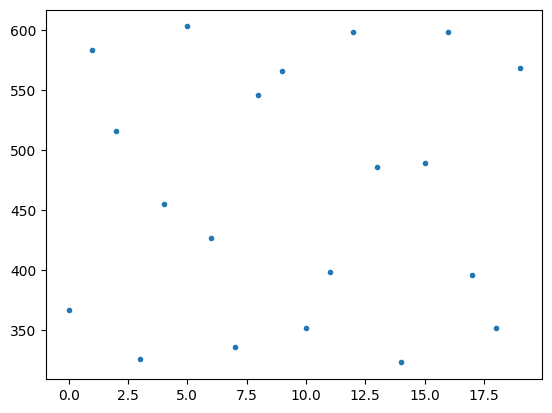

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcb96d8aa20>

In [306]:
plot(x_rx[1:20],".")

In [5]:
bytesavailable(sp)

4095

In [ ]:
using Pkg
Pkg.add("FFTW")
using PyPlot

## Transmit and Sample

Time taken to sample 0.05840000000000002 s
Time between transmitting and receiving 4182 us
Finished Reading
Number of samples received 29200
(

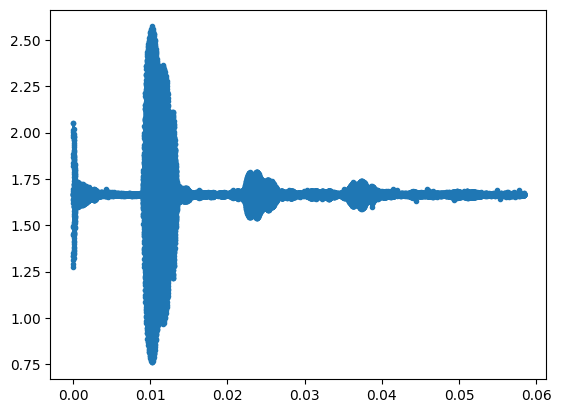

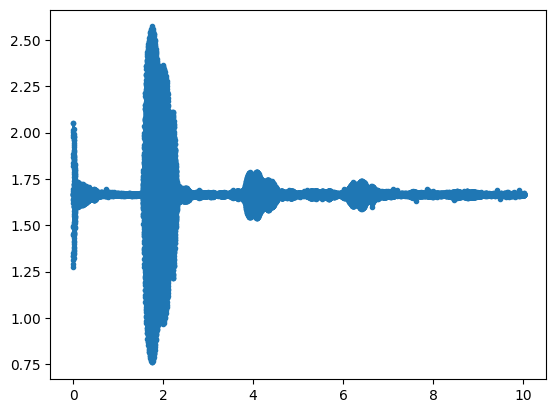

29200,)
(29201,)


In [15]:
#Setup variables
S=29200 #Number of samples expected
c = 343 # Speed of sound in air in m/s
i =1 #data samples recieved
x_rx=zeros(Int16,S) # Samples values recieved

# Clear buffer
while (bytesavailable(sp)>0)
    read(sp,UInt8)
end

# Transmit and Sample command
write(sp,"t") 

while bytesavailable(sp) < 1
    continue # wait for a response    
end  
sleep(0.05) # This extra delay helps with reliability - it gives the micro time to send all it needs to

# Get timing information
time = parse(Int,readline(sp)) 
timeSeconds = time*10^-6
println("Time taken to sample ",timeSeconds, " s")

timeBetweenTransmitAndRecieve = parse(Int,readline(sp))
println("Time between transmitting and receiving ",timeBetweenTransmitAndRecieve, " us")

# Create time and distance arrays
dt=timeSeconds/S # Time per sample
t = collect(0:dt:timeSeconds); # t=0:dt:t_max defines a “range”.
r = c*t/2;

#Grab samples
write(sp,"p") # Print DMA buffer

while bytesavailable(sp) < 1   
    continue # wait for a response    
end 

sleep(0.05)

while true
    if bytesavailable(sp) < 2
        sleep(0.080) # Wait and check again
        if bytesavailable(sp) < 2
            println("Finished Reading")
            break
        end
    end
    #s = (readline(sp))
    #println(i," ",s)
    #x_rx[i]=(parse(Int16,(s)))
    x_rx[i]=(parse(Int16,(readline(sp))))
    #println(i," ",x_rx[i])
    i += 1    
end

 println("Number of samples received ", i-1)

# Convert ADC output to voltage
v_rx=(x_rx*(3.3/(2^12)))

#Plot
figure()
plot(t[1:29200],v_rx,".-")
show()

figure()
plot(r[1:29200],v_rx,".-")
show()

println(size(v_rx))
println(size(t))

In [16]:
print(x_rx)

Int16[2067, 2072, 2066, 2067, 2070, 2080, 2074, 2008, 2258, 2456, 2545, 2502, 2339, 2104, 1852, 1659, 1582, 1628, 1794, 2030, 2278, 2468, 2544, 2487, 2322, 2094, 1855, 1678, 1604, 1655, 1803, 2036, 2259, 2430, 2508, 2462, 2316, 2108, 1886, 1716, 1640, 1673, 1807, 2009, 2220, 2386, 2473, 2450, 2326, 2130, 1922, 1750, 1666, 1686, 1805, 1986, 2204, 2364, 2450, 2434, 2318, 2138, 1939, 1777, 1693, 1707, 1819, 1991, 2182, 2332, 2414, 2399, 2297, 2136, 1957, 1813, 1737, 1753, 1843, 1993, 2158, 2291, 2360, 2352, 2269, 2136, 1989, 1866, 1797, 1803, 1874, 1987, 2125, 2240, 2304, 2306, 2248, 2142, 2024, 1921, 1851, 1841, 1893, 1983, 2095, 2208, 2263, 2273, 2229, 2145, 2044, 1950, 1893, 1876, 1912, 1986, 2079, 2167, 2221, 2235, 2205, 2138, 2057, 1977, 1926, 1914, 1941, 1995, 2070, 2132, 2192, 2194, 2174, 2123, 2062, 2008, 1967, 1955, 1973, 2014, 2062, 2111, 2165, 2158, 2143, 2114, 2076, 2037, 2009, 1994, 1998, 2017, 2046, 2080, 2107, 2110, 2127, 2118, 2091, 2065, 2042, 2020, 2013, 2018, 2035, 2059

, 2071, 2077, 2075, 2076, 2074, 2069, 2064, 2066, 2063, 2058, 2063, 2066, 2070, 2075, 2075, 2076, 2074, 2072, 2063, 2063, 2057, 2058, 2062, 2061, 2075, 2071, 2076, 2075, 2074, 2071, 2069, 2066, 2061, 2062, 2061, 2062, 2068, 2070, 2075, 2074, 2075, 2072, 2072, 2067, 2064, 2063, 2061, 2064, 2065, 2068, 2071, 2075, 2077, 2074, 2073, 2071, 2065, 2062, 2062, 2061, 2063, 2070, 2073, 2075, 2075, 2076, 2072, 2070, 2069, 2064, 2065, 2072, 2065, 2068, 2082, 2072, 2072, 2075, 2077, 2068, 2069, 2064, 2064, 2055, 2065, 2066, 2071, 2072, 2072, 2072, 2073, 2072, 2068, 2066, 2071, 2064, 2063, 2060, 2065, 2085, 2072, 2074, 2073, 2070, 2068, 2066, 2066, 2063, 2065, 2067, 2067, 2071, 2072, 2074, 2074, 2072, 2068, 2068, 2067, 2065, 2064, 2065, 2068, 2069, 2086, 2073, 2070, 2071, 2069, 2068, 2067, 2065, 2061, 2062, 2062, 2068, 2070, 2072, 2074, 2076, 2070, 2072, 2068, 2065, 2065, 2065, 2066, 2062, 2069, 2086, 2073, 2069, 2068, 2069, 2068, 2064, 2064, 2066, 2062, 2065, 2068, 2069, 2069, 2066, 2069, 2069, 20

 2070, 2069, 2068, 2067, 2069, 2069, 2066, 2071, 2070, 2070, 2067, 2069, 2070, 2071, 2068, 2068, 2072, 2068, 2069, 2066, 2066, 2067, 2068, 2067, 2067, 2066, 2068, 2068, 2067, 2073, 2067, 2068, 2063, 2065, 2066, 2068, 2068, 2067, 2066, 2068, 2067, 2070, 2067, 2067, 2065, 2066, 2067, 2068, 2064, 2069, 2066, 2065, 2068, 2068, 2070, 2071, 2066, 2068, 2066, 2069, 2067, 2070, 2071, 2071, 2072, 2069, 2069, 2066, 2068, 2068, 2065, 2066, 2070, 2068, 2067, 2070, 2066, 2072, 2069, 2069, 2068, 2064, 2066, 2066, 2067, 2067, 2067, 2068, 2068, 2069, 2069, 2069, 2065, 2067, 2065, 2064, 2064, 2067, 2068, 2068, 2069, 2071, 2069, 2070, 2071, 2072, 2068, 2066, 2067, 2068, 2066, 2068, 2069, 2071, 2071, 2071, 2072, 2067, 2068, 2066, 2066, 2068, 2070, 2068, 2070, 2071, 2074, 2069, 2069, 2071, 2071, 2066, 2067, 2065, 2067, 2068, 2069, 2068, 2069, 2068, 2069, 2069, 2067, 2066, 2065, 2065, 2064, 2069, 2066, 2067, 2068, 2070, 2070, 2068, 2072, 2069, 2066, 2065, 2065, 2066, 2067, 2069, 2071, 2071, 2071, 2071, 207

, 1265, 1490, 1860, 2284, 2649, 2865, 2882, 2688, 2330, 1904, 1524, 1281, 1243, 1413, 1749, 2164, 2557, 2822, 2893, 2752, 2436, 2017, 1617, 1330, 1235, 1350, 1650, 2056, 2466, 2772, 2899, 2806, 2534, 2130, 1712, 1391, 1240, 1301, 1562, 1943, 2365, 2704, 2881, 2847, 2616, 2232, 1824, 1462, 1260, 1265, 1477, 1840, 2282, 2635, 2859, 2877, 2684, 2344, 1921, 1541, 1308, 1243, 1406, 1740, 2158, 2552, 2818, 2889, 2753, 2437, 2025, 1623, 1335, 1237, 1350, 1648, 2055, 2459, 2770, 2893, 2808, 2526, 2134, 1714, 1392, 1242, 1301, 1560, 1951, 2369, 2710, 2884, 2850, 2609, 2232, 1809, 1453, 1258, 1263, 1478, 1846, 2275, 2643, 2866, 2879, 2688, 2330, 1915, 1527, 1283, 1239, 1409, 1751, 2172, 2566, 2830, 2899, 2750, 2426, 2007, 1605, 1317, 1224, 1348, 1660, 2071, 2487, 2788, 2908, 2810, 2519, 2109, 1695, 1366, 1223, 1299, 1568, 1970, 2396, 2732, 2901, 2856, 2600, 2211, 1785, 1428, 1229, 1259, 1487, 1879, 2304, 2672, 2886, 2887, 2678, 2306, 1876, 1508, 1261, 1224, 1414, 1767, 2203, 2599, 2858, 2911, 27

 2039, 2031, 2026, 2032, 2042, 2066, 2084, 2100, 2110, 2105, 2095, 2073, 2053, 2037, 2026, 2025, 2037, 2056, 2076, 2096, 2108, 2109, 2097, 2078, 2059, 2033, 2028, 2024, 2032, 2047, 2072, 2092, 2105, 2108, 2104, 2089, 2068, 2045, 2031, 2024, 2027, 2043, 2062, 2086, 2104, 2108, 2104, 2094, 2077, 2054, 2029, 2029, 2028, 2037, 2056, 2075, 2101, 2108, 2112, 2096, 2078, 2056, 2040, 2029, 2028, 2032, 2051, 2072, 2092, 2106, 2105, 2102, 2085, 2066, 2046, 2025, 2029, 2031, 2047, 2067, 2085, 2104, 2108, 2100, 2090, 2072, 2051, 2035, 2030, 2031, 2043, 2062, 2082, 2099, 2109, 2107, 2093, 2076, 2056, 2040, 2023, 2034, 2036, 2054, 2072, 2093, 2105, 2105, 2097, 2079, 2063, 2045, 2034, 2033, 2040, 2053, 2072, 2089, 2101, 2104, 2099, 2084, 2063, 2049, 2038, 2027, 2044, 2051, 2062, 2081, 2094, 2102, 2096, 2087, 2069, 2053, 2040, 2038, 2043, 2054, 2063, 2082, 2094, 2100, 2096, 2089, 2072, 2059, 2045, 2039, 2031, 2051, 2061, 2074, 2087, 2094, 2096, 2089, 2076, 2063, 2050, 2040, 2043, 2051, 2063, 2074, 208

 2068, 2066, 2066, 2066, 2073, 2072, 2069, 2071, 2071, 2070, 2070, 2068, 2069, 2069, 2066, 2072, 2067, 2070, 2070, 2072, 2072, 2071, 2071, 2069, 2074, 2070, 2065, 2069, 2069, 2073, 2071, 2072, 2072, 2073, 2071, 2072, 2068, 2070, 2064, 2067, 2067, 2071, 2070, 2070, 2072, 2073, 2071, 2072, 2071, 2075, 2071, 2070, 2066, 2069, 2070, 2069, 2072, 2071, 2072, 2071, 2070, 2069, 2071, 2069, 2069, 2069, 2066, 2068, 2069, 2068, 2070, 2070, 2073, 2070, 2073, 2069, 2066, 2065, 2066, 2070, 2068, 2069, 2067, 2076, 2073, 2072, 2070, 2070, 2067, 2067, 2066, 2069, 2062, 2070, 2070, 2070, 2072, 2069, 2072, 2077, 2076, 2068, 2066, 2063, 2067, 2069, 2067, 2069, 2069, 2072, 2072, 2073, 2071, 2070, 2067, 2066, 2069, 2063, 2068, 2068, 2069, 2072, 2070, 2074, 2075, 2074, 2069, 2065, 2059, 2063, 2066, 2066, 2068, 2069, 2070, 2073, 2075, 2073, 2070, 2069, 2066, 2063, 2064, 2065, 2066, 2069, 2070, 2071, 2073, 2076, 2077, 2067, 2068, 2063, 2064, 2063, 2065, 2064, 2066, 2070, 2075, 2076, 2075, 2075, 2067, 2064, 206

, 2002, 2049, 2102, 2147, 2168, 2169, 2142, 2093, 2044, 1995, 1966, 1959, 1979, 2019, 2074, 2126, 2162, 2171, 2164, 2119, 2068, 2019, 1977, 1956, 1964, 1996, 2046, 2096, 2147, 2173, 2175, 2150, 2103, 2047, 1997, 1962, 1953, 1971, 2014, 2070, 2126, 2169, 2184, 2169, 2132, 2078, 2019, 1971, 1949, 1956, 1989, 2043, 2097, 2152, 2183, 2183, 2155, 2101, 2045, 1989, 1953, 1943, 1965, 2014, 2075, 2131, 2176, 2188, 2183, 2133, 2073, 2008, 1960, 1940, 1946, 1981, 2042, 2106, 2161, 2191, 2193, 2160, 2103, 2038, 1980, 1942, 1936, 1962, 2013, 2079, 2146, 2190, 2197, 2187, 2131, 2065, 1998, 1951, 1932, 1941, 1985, 2050, 2114, 2174, 2201, 2196, 2158, 2095, 2029, 1958, 1930, 1924, 1960, 2021, 2092, 2154, 2203, 2207, 2186, 2123, 2052, 1983, 1935, 1918, 1941, 1990, 2063, 2135, 2187, 2211, 2198, 2153, 2082, 2012, 1950, 1920, 1925, 1967, 2033, 2108, 2173, 2210, 2207, 2176, 2112, 2037, 1966, 1926, 1916, 1945, 2005, 2079, 2152, 2199, 2217, 2195, 2139, 2064, 1990, 1935, 1913, 1930, 1980, 2053, 2130, 2190, 22

 2064, 2062, 2066, 2070, 2073, 2073, 2073, 2076, 2066, 2069, 2066, 2065, 2066, 2069, 2064, 2066, 2071, 2071, 2073, 2075, 2071, 2065, 2070, 2068, 2066, 2065, 2065, 2067, 2069, 2068, 2073, 2073, 2073, 2069, 2067, 2064, 2064, 2069, 2070, 2060, 2066, 2067, 2073, 2071, 2070, 2071, 2070, 2070, 2068, 2066, 2070, 2067, 2066, 2072, 2069, 2071, 2073, 2074, 2068, 2069, 2068, 2066, 2070, 2071, 2067, 2068, 2069, 2070, 2070, 2073, 2071, 2071, 2071, 2071, 2070, 2070, 2069, 2068, 2066, 2066, 2071, 2072, 2073, 2072, 2064, 2070, 2070, 2071, 2064, 2067, 2068, 2065, 2073, 2069, 2069, 2070, 2074, 2071, 2070, 2070, 2073, 2070, 2064, 2066, 2067, 2069, 2071, 2072, 2076, 2075, 2075, 2072, 2074, 2073, 2067, 2066, 2064, 2065, 2065, 2072, 2072, 2070, 2076, 2076, 2071, 2073, 2066, 2064, 2063, 2069, 2066, 2069, 2073, 2071, 2072, 2073, 2072, 2073, 2071, 2062, 2062, 2065, 2067, 2067, 2074, 2073, 2076, 2073, 2074, 2069, 2067, 2065, 2064, 2062, 2064, 2066, 2067, 2072, 2075, 2074, 2072, 2070, 2070, 2071, 2065, 2063, 206

, 2082, 2090, 2087, 2084, 2073, 2064, 2059, 2050, 2041, 2051, 2060, 2069, 2078, 2086, 2088, 2086, 2074, 2073, 2059, 2055, 2048, 2049, 2059, 2067, 2079, 2086, 2089, 2087, 2084, 2072, 2063, 2056, 2046, 2050, 2053, 2066, 2075, 2080, 2089, 2089, 2083, 2075, 2068, 2060, 2048, 2046, 2051, 2054, 2070, 2080, 2085, 2087, 2085, 2077, 2070, 2062, 2054, 2050, 2050, 2054, 2064, 2071, 2081, 2089, 2087, 2081, 2074, 2065, 2060, 2054, 2052, 2055, 2062, 2070, 2079, 2083, 2085, 2085, 2077, 2066, 2061, 2058, 2053, 2053, 2055, 2065, 2073, 2078, 2082, 2081, 2079, 2074, 2065, 2059, 2055, 2052, 2055, 2059, 2068, 2077, 2081, 2084, 2080, 2076, 2067, 2062, 2060, 2051, 2055, 2054, 2065, 2069, 2077, 2080, 2080, 2078, 2073, 2068, 2062, 2058, 2055, 2056, 2062, 2069, 2072, 2079, 2082, 2081, 2075, 2070, 2068, 2059, 2055, 2057, 2059, 2065, 2066, 2073, 2080, 2081, 2080, 2078, 2070, 2066, 2060, 2055, 2058, 2061, 2066, 2073, 2077, 2078, 2080, 2078, 2073, 2065, 2068, 2058, 2053, 2056, 2063, 2067, 2075, 2077, 2081, 2077, 20

 2063, 2074, 2083, 2084, 2084, 2079, 2074, 2065, 2056, 2051, 2049, 2050, 2061, 2071, 2074, 2087, 2086, 2087, 2078, 2067, 2058, 2054, 2051, 2053, 2057, 2068, 2078, 2087, 2086, 2095, 2077, 2072, 2062, 2056, 2049, 2051, 2056, 2064, 2107, 2071, 2089, 2086, 2085, 2074, 2065, 2054, 2049, 2049, 2046, 2067, 2070, 2082, 2090, 2090, 2084, 2077, 2066, 2058, 2043, 2051, 2048, 2057, 2066, 2075, 2081, 2091, 2088, 2081, 2075, 2064, 2053, 2051, 2049, 2055, 2063, 2074, 2082, 2090, 2096, 2087, 2074, 2063, 2055, 2050, 2046, 2050, 2055, 2072, 2083, 2084, 2095, 2086, 2079, 2072, 2058, 2051, 2054, 2052, 2056, 2067, 2080, 2083, 2094, 2089, 2080, 2064, 2059, 2052, 2046, 2048, 2053, 2063, 2076, 2080, 2082, 2088, 2087, 2072, 2064, 2054, 2050, 2047, 2054, 2061, 2068, 2079, 2089, 2093, 2087, 2078, 2068, 2058, 2059, 2047, 2049, 2060, 2068, 2077, 2086, 2083, 2087, 2071, 2077, 2059, 2051, 2047, 2050, 2055, 2062, 2072, 2077, 2093, 2089, 2084, 2074, 2062, 2056, 2050, 2049, 2046, 2066, 2075, 2079, 2085, 2082, 2087, 207

, 2067, 2048, 2033, 2028, 2031, 2046, 2064, 2094, 2104, 2108, 2105, 2084, 2071, 2051, 2033, 2028, 2029, 2045, 2067, 2083, 2103, 2111, 2105, 2092, 2072, 2052, 2034, 2028, 2026, 2041, 2060, 2080, 2100, 2110, 2113, 2097, 2073, 2055, 2037, 2027, 2025, 2034, 2052, 2079, 2102, 2112, 2114, 2100, 2082, 2058, 2038, 2029, 2019, 2034, 2052, 2076, 2097, 2116, 2118, 2102, 2086, 2061, 2039, 2022, 2021, 2026, 2040, 2071, 2097, 2113, 2117, 2109, 2087, 2064, 2037, 2020, 2020, 2027, 2045, 2070, 2098, 2110, 2120, 2122, 2089, 2067, 2043, 2023, 2020, 2023, 2045, 2060, 2090, 2109, 2114, 2110, 2096, 2073, 2068, 2022, 2017, 2022, 2035, 2060, 2086, 2108, 2117, 2128, 2101, 2073, 2049, 2024, 2016, 2021, 2032, 2071, 2080, 2102, 2118, 2116, 2106, 2080, 2055, 2033, 1984, 2014, 2031, 2053, 2078, 2106, 2116, 2117, 2112, 2120, 2056, 2033, 2018, 2016, 2030, 2052, 2072, 2097, 2112, 2118, 2108, 2088, 2064, 2036, 2018, 2015, 2023, 2041, 2077, 2095, 2114, 2119, 2111, 2098, 2066, 2043, 2024, 2007, 2023, 2043, 2068, 2094, 21

 2070, 2073, 2071, 2068, 2066, 2068, 2066, 2066, 2066, 2067, 2070, 2075, 2071, 2073, 2070, 2068, 2068, 2068, 2065, 2065, 2065, 2066, 2067, 2068, 2069, 2069, 2072, 2070, 2067, 2065, 2067, 2068, 2067, 2069, 2065, 2071, 2071, 2071, 2071, 2070, 2069, 2067, 2071, 2070, 2069, 2064, 2068, 2069, 2070, 2072, 2067, 2073, 2075, 2072, 2066, 2067, 2068, 2070, 2069, 2078, 2064, 2073, 2069, 2071, 2069, 2069, 2099, 2059, 2068, 2065, 2070, 2068, 2069, 2067, 2074, 2066, 2073, 2067, 2067, 2067, 2069, 2069, 2066, 2064, 2068, 2066, 2070, 2068, 2071, 2072, 2069, 2068, 2068, 2068, 2065, 2068, 2067, 2068, 2066, 2065, 2064, 2071, 2066, 2068, 2067, 2069, 2068, 2069, 2068, 2066, 2065, 2065, 2066, 2070, 2069, 2069, 2069, 2068, 2068, 2067, 2066, 2066, 2066, 2066, 2069, 2064, 2071, 2073, 2070, 2068, 2069, 2071, 2069, 2067, 2068, 2066, 2068, 2063, 2071, 2070, 2068, 2069, 2069, 2071, 2069, 2066, 2065, 2069, 2064, 2067, 2068, 2070, 2071, 2068, 2068, 2068, 2070, 2063, 2066, 2065, 2062, 2067, 2067, 2071, 2072, 2070, 207

, 2073, 2071, 2069, 2078, 2072, 2068, 2065, 2067, 2070, 2073, 2076, 2067, 2064, 2064, 2066, 2065, 2072, 2068, 2065, 2071, 2072, 2072, 2073, 2069, 2070, 2066, 2068, 2071, 2075, 2067, 2066, 2066, 2065, 2066, 2067, 2069, 2066, 2071, 2068, 2067, 2068, 2073, 2073, 2072, 2071, 2072, 2076, 2070, 2068, 2070, 2066, 2066, 2068, 2070, 2070, 2064, 2068, 2068, 2069, 2070, 2065, 2068, 2067, 2067, 2071, 2072, 2073, 2071, 2073, 2074, 2072, 2069, 2076, 2069, 2067, 2062, 2063, 2066, 2072, 2073, 2070, 2069, 2070, 2071, 2073, 2069, 2068, 2070, 2069, 2069, 2072, 2076, 2072, 2073, 2071, 2070, 2065, 2065, 2063, 2064, 2065, 2068, 2067, 2072, 2073, 2071, 2072, 2076, 2072, 2070, 2069, 2068, 2068, 2069, 2068, 2071, 2073, 2077, 2069, 2065, 2065, 2062, 2062, 2062, 2062, 2066, 2068, 2070, 2078, 2079, 2078, 2076, 2073, 2071, 2068, 2068, 2066, 2066, 2066, 2073, 2068, 2070, 2072, 2066, 2068, 2066, 2067, 2064, 2066, 2068, 2069, 2071, 2072, 2080, 2078, 2084, 2070, 2067, 2066, 2062, 2063, 2062, 2064, 2061, 2066, 2071, 20

 2054, 2060, 2068, 2073, 2080, 2079, 2079, 2079, 2071, 2067, 2063, 2058, 2057, 2050, 2071, 2073, 2080, 2081, 2082, 2074, 2070, 2064, 2061, 2059, 2062, 2062, 2066, 2074, 2076, 2079, 2080, 2078, 2071, 2066, 2059, 2059, 2056, 2060, 2067, 2072, 2080, 2083, 2080, 2077, 2067, 2064, 2057, 2057, 2054, 2060, 2066, 2072, 2080, 2079, 2082, 2076, 2068, 2062, 2059, 2056, 2057, 2060, 2066, 2073, 2079, 2083, 2080, 2078, 2071, 2067, 2059, 2055, 2056, 2060, 2067, 2064, 2079, 2077, 2085, 2076, 2068, 2063, 2058, 2055, 2057, 2060, 2064, 2070, 2077, 2081, 2082, 2080, 2073, 2066, 2058, 2054, 2052, 2057, 2063, 2071, 2075, 2080, 2084, 2079, 2075, 2066, 2057, 2054, 2054, 2057, 2064, 2077, 2078, 2083, 2085, 2079, 2076, 2067, 2057, 2053, 2053, 2052, 2061, 2067, 2074, 2079, 2082, 2078, 2074, 2064, 2058, 2052, 2054, 2058, 2063, 2070, 2074, 2081, 2082, 2083, 2079, 2068, 2061, 2050, 2057, 2051, 2054, 2068, 2073, 2078, 2086, 2085, 2078, 2070, 2061, 2050, 2049, 2050, 2060, 2068, 2073, 2078, 2085, 2084, 2080, 2072, 206

, 2067, 2067, 2075, 2073, 2074, 2068, 2067, 2068, 2067, 2068, 2066, 2067, 2069, 2069, 2072, 2072, 2071, 2070, 2068, 2066, 2066, 2064, 2066, 2067, 2067, 2066, 2069, 2071, 2072, 2072, 2070, 2068, 2067, 2069, 2068, 2064, 2067, 2068, 2069, 2071, 2071, 2071, 2069, 2068, 2065, 2065, 2064, 2065, 2064, 2065, 2069, 2070, 2074, 2072, 2070, 2069, 2065, 2066, 2058, 2066, 2067, 2066, 2067, 2070, 2075, 2070, 2072, 2070, 2070, 2061, 2068, 2064, 2064, 2067, 2068, 2069, 2071, 2072, 2070, 2071, 2067, 2064, 2068, 2064, 2067, 2068, 2070, 2070, 2072, 2072, 2071, 2072, 2071, 2067, 2062, 2071, 2069, 2067, 2068, 2065, 2068, 2073, 2074, 2074, 2072, 2072, 2064, 2064, 2067, 2066, 2066, 2068, 2068, 2069, 2069, 2070, 2072, 2067, 2066, 2066, 2066, 2066, 2067, 2068, 2068, 2069, 2071, 2073, 2072, 2068, 2068, 2066, 2063, 2065, 2065, 2068, 2067, 2070, 2072, 2073, 2072, 2072, 2069, 2068, 2068, 2066, 2066, 2066, 2068, 2067, 2071, 2069, 2074, 2072, 2070, 2068, 2066, 2064, 2064, 2071, 2068, 2071, 2071, 2071, 2100, 2065, 20

 2060, 2067, 2067, 2068, 2065, 2067, 2064, 2068, 2068, 2062, 2067, 2066, 2067, 2067, 2070, 2068, 2068, 2067, 2066, 2062, 2067, 2070, 2068, 2067, 2068, 2073, 2071, 2070, 2068, 2067, 2067, 2068, 2070, 2069, 2070, 2069, 2068, 2069, 2070, 2070, 2069, 2067, 2066, 2067, 2067, 2069, 2068, 2068, 2068, 2068, 2070, 2069, 2068, 2069, 2064, 2068, 2068, 2068, 2067, 2068, 2066, 2065, 2065, 2067, 2067, 2065, 2071, 2067, 2067, 2068, 2081, 2067, 2069, 2067, 2068, 2068, 2068, 2067, 2068, 2065, 2067, 2067, 2070, 2072, 2072, 2069, 2066, 2071, 2068, 2068, 2067, 2068, 2066, 2066, 2066, 2070, 2073, 2073, 2069, 2072, 2071, 2066, 2069, 2068, 2066, 2067, 2066, 2068, 2068, 2072, 2070, 2068, 2068, 2066, 2065, 2066, 2066, 2064, 2068, 2068, 2069, 2069, 2070, 2069, 2066, 2065, 2065, 2066, 2064, 2068, 2067, 2065, 2071, 2071, 2073, 2071, 2070, 2071, 2068, 2068, 2067, 2066, 2068, 2067, 2064, 2067, 2072, 2071, 2074, 2064, 2067, 2070, 2068, 2065, 2068, 2070, 2070, 2071, 2072, 2072, 2070, 2069, 2068, 2066, 2068, 2070, 206

In [19]:
print(v_rx)

[1.66531, 1.66934, 1.6645, 1.66531, 1.66772, 1.67578, 1.67095, 1.61777, 1.81919, 1.97871, 2.05042, 2.01577, 1.88445, 1.69512, 1.49209, 1.3366, 1.27456, 1.31162, 1.44536, 1.6355, 1.8353, 1.98838, 2.04961, 2.00369, 1.87075, 1.68706, 1.49451, 1.3519, 1.29229, 1.33337, 1.45261, 1.64033, 1.82, 1.95776, 2.02061, 1.98354, 1.86592, 1.69834, 1.51948, 1.38252, 1.32129, 1.34788, 1.45583, 1.61858, 1.78857, 1.92231, 1.99241, 1.97388, 1.87397, 1.71606, 1.54849, 1.40991, 1.34224, 1.35835, 1.45422, 1.60005, 1.77568, 1.90459, 1.97388, 1.96099, 1.86753, 1.72251, 1.56218, 1.43167, 1.36399, 1.37527, 1.4655, 1.60408, 1.75796, 1.87881, 1.94487, 1.93279, 1.85061, 1.7209, 1.57668, 1.46067, 1.39944, 1.41233, 1.48484, 1.60569, 1.73862, 1.84578, 1.90137, 1.89492, 1.82805, 1.7209, 1.60247, 1.50337, 1.44778, 1.45261, 1.50981, 1.60085, 1.71204, 1.80469, 1.85625, 1.85786, 1.81113, 1.72573, 1.63066, 1.54768, 1.49128, 1.48323, 1.52512, 1.59763, 1.68787, 1.77891, 1.82322, 1.83127, 1.79583, 1.72815, 1.64678, 1.57104, 1.

 1.65, 1.64517, 1.64597, 1.65161, 1.66128, 1.66692, 1.679, 1.68384, 1.68464, 1.679, 1.67256, 1.66128, 1.65161, 1.64597, 1.64436, 1.65, 1.66047, 1.67095, 1.68062, 1.68545, 1.68464, 1.68062, 1.67256, 1.67014, 1.65161, 1.64275, 1.64355, 1.64919, 1.66128, 1.67014, 1.67981, 1.68706, 1.68625, 1.679, 1.66934, 1.66128, 1.65483, 1.64355, 1.64678, 1.65, 1.66047, 1.67175, 1.68142, 1.68787, 1.68625, 1.67981, 1.67336, 1.66128, 1.65161, 1.64194, 1.64919, 1.65081, 1.65806, 1.67014, 1.67981, 1.679, 1.68464, 1.68142, 1.67256, 1.66208, 1.65403, 1.64678, 1.64517, 1.65, 1.65483, 1.66611, 1.67659, 1.68787, 1.68787, 1.68464, 1.67417, 1.6637, 1.65322, 1.64597, 1.64517, 1.64678, 1.65886, 1.66531, 1.67659, 1.68625, 1.68384, 1.68464, 1.67417, 1.66208, 1.65322, 1.64758, 1.64597, 1.64355, 1.65403, 1.66772, 1.68062, 1.68706, 1.68787, 1.68545, 1.67498, 1.6645, 1.65483, 1.64758, 1.64355, 1.64839, 1.65645, 1.66531, 1.67739, 1.68545, 1.68706, 1.68464, 1.67739, 1.66611, 1.65483, 1.64678, 1.64194, 1.64919, 1.65, 1.6645,

, 1.66692, 1.66772, 1.66772, 1.66934, 1.67014, 1.67014, 1.66934, 1.66531, 1.6645, 1.66611, 1.66692, 1.66531, 1.66772, 1.67014, 1.66934, 1.66692, 1.66772, 1.66772, 1.66772, 1.66934, 1.66531, 1.6645, 1.66531, 1.66611, 1.66692, 1.66934, 1.66853, 1.66934, 1.66772, 1.66934, 1.66772, 1.66934, 1.66692, 1.6645, 1.66208, 1.66772, 1.66692, 1.66611, 1.66934, 1.66772, 1.66772, 1.66853, 1.66772, 1.66853, 1.67336, 1.66692, 1.6645, 1.66772, 1.66692, 1.66772, 1.66853, 1.67014, 1.67095, 1.66853, 1.66772, 1.66692, 1.66531, 1.66772, 1.66611, 1.66692, 1.66692, 1.66853, 1.67014, 1.66934, 1.66772, 1.66772, 1.66611, 1.66531, 1.66853, 1.67739, 1.66853, 1.6645, 1.66692, 1.66611, 1.66692, 1.67014, 1.67014, 1.66853, 1.66692, 1.6645, 1.66934, 1.66853, 1.66772, 1.66611, 1.66531, 1.66611, 1.66772, 1.66772, 1.66934, 1.66611, 1.66692, 1.66611, 1.66611, 1.6645, 1.67578, 1.6637, 1.6645, 1.66772, 1.67417, 1.66692, 1.66692, 1.66853, 1.66611, 1.66611, 1.6645, 1.66531, 1.66772, 1.66531, 1.66531, 1.67095, 1.66611, 1.66772, 

 1.66692, 1.66611, 1.66853, 1.66692, 1.66853, 1.66772, 1.66692, 1.66611, 1.66772, 1.66692, 1.66934, 1.66934, 1.66208, 1.66934, 1.6645, 1.6645, 1.66611, 1.66611, 1.66772, 1.66531, 1.66128, 1.66772, 1.66611, 1.66692, 1.66531, 1.66611, 1.66692, 1.66611, 1.66531, 1.66692, 1.66611, 1.66611, 1.66531, 1.66611, 1.66531, 1.66611, 1.66772, 1.66611, 1.66531, 1.6637, 1.66531, 1.66611, 1.66772, 1.66531, 1.66531, 1.66611, 1.66611, 1.66772, 1.66692, 1.66692, 1.6645, 1.6637, 1.6645, 1.6637, 1.6637, 1.66611, 1.6645, 1.6645, 1.66772, 1.66611, 1.66611, 1.66853, 1.66611, 1.6645, 1.66611, 1.66611, 1.6637, 1.6637, 1.66692, 1.66611, 1.66531, 1.6645, 1.66611, 1.6645, 1.66772, 1.6637, 1.66692, 1.6637, 1.66531, 1.6645, 1.66611, 1.66611, 1.66531, 1.6645, 1.66611, 1.66692, 1.66934, 1.66531, 1.66692, 1.66289, 1.6637, 1.6645, 1.66611, 1.66853, 1.66692, 1.66772, 1.66692, 1.66772, 1.66772, 1.66692, 1.6637, 1.66531, 1.66772, 1.66611, 1.66772, 1.66772, 1.66772, 1.6645, 1.66611, 1.66611, 1.66611, 1.66934, 1.66692, 1.665

.33401, 2.34126, 2.17529, 1.878, 1.52754, 1.21414, 1.01353, 0.980493, 1.11987, 1.39783, 1.74185, 2.07297, 2.2897, 2.35576, 2.23894, 1.97549, 1.63389, 1.30195, 1.06267, 0.974048, 1.0667, 1.30759, 1.64114, 1.97791, 2.23652, 2.34851, 2.28647, 2.06411, 1.73782, 1.39541, 1.12229, 0.986938, 1.0248, 1.223, 1.53721, 1.88203, 2.17126, 2.33079, 2.32112, 2.14146, 1.83853, 1.4929, 1.19561, 1.01272, 0.997412, 1.15854, 1.44214, 1.78293, 2.09714, 2.29695, 2.33562, 2.20269, 1.93037, 1.59038, 1.27134, 1.05139, 0.989355, 1.09893, 1.35271, 1.68545, 2.01577, 2.25183, 2.34045, 2.25828, 2.01819, 1.68867, 1.35674, 1.10054, 0.991772, 1.05381, 1.27053, 1.58958, 1.92715, 2.20027, 2.33159, 2.29614, 2.09473, 1.78535, 1.44456, 1.15935, 1.00627, 1.01917, 1.20044, 1.49854, 1.84014, 2.1342, 2.30823, 2.32192, 2.16562, 1.8772, 1.53398, 1.22783, 1.03206, 1.00144, 1.1384, 1.40911, 1.74346, 2.06008, 2.27358, 2.33079, 2.21719, 1.9626, 1.62502, 1.30276, 1.07153, 0.994995, 1.08765, 1.32935, 1.65645, 1.98677, 2.2333, 2.33562,

 1.68223, 1.68142, 1.67578, 1.66692, 1.65725, 1.65645, 1.64517, 1.65242, 1.65564, 1.6645, 1.67095, 1.67578, 1.67981, 1.67659, 1.67659, 1.66853, 1.66289, 1.65645, 1.65645, 1.65645, 1.65967, 1.66531, 1.66772, 1.67578, 1.67256, 1.67417, 1.67175, 1.66611, 1.66289, 1.65886, 1.65806, 1.65564, 1.66853, 1.66692, 1.66772, 1.66853, 1.67014, 1.66934, 1.66128, 1.66692, 1.66208, 1.66531, 1.66611, 1.66611, 1.67014, 1.67095, 1.66772, 1.66772, 1.66692, 1.6637, 1.6637, 1.66289, 1.66208, 1.6637, 1.66692, 1.66934, 1.67014, 1.67981, 1.66934, 1.66531, 1.65725, 1.65806, 1.65483, 1.65725, 1.66047, 1.6637, 1.67095, 1.66853, 1.6782, 1.67739, 1.67498, 1.66853, 1.66208, 1.65725, 1.65161, 1.65806, 1.65161, 1.66047, 1.67095, 1.67739, 1.68223, 1.67981, 1.679, 1.66772, 1.65403, 1.64919, 1.64758, 1.64758, 1.65, 1.65886, 1.67014, 1.67981, 1.68867, 1.68142, 1.68545, 1.67336, 1.66208, 1.65, 1.64436, 1.64355, 1.64839, 1.6637, 1.66208, 1.67739, 1.68706, 1.68948, 1.68545, 1.68062, 1.6637, 1.65161, 1.65483, 1.64033, 1.64517

1.67256, 1.67578, 1.6782, 1.67498, 1.67336, 1.66208, 1.66289, 1.65645, 1.65483, 1.65483, 1.66047, 1.66611, 1.67175, 1.6782, 1.67739, 1.67659, 1.67256, 1.66853, 1.65967, 1.65645, 1.65403, 1.65806, 1.65806, 1.66289, 1.66772, 1.67336, 1.6782, 1.67578, 1.67417, 1.66853, 1.66128, 1.65967, 1.65645, 1.65483, 1.65645, 1.6637, 1.66611, 1.67336, 1.68062, 1.67659, 1.67578, 1.67014, 1.6645, 1.65967, 1.65564, 1.65967, 1.65886, 1.66128, 1.66611, 1.67256, 1.67498, 1.67739, 1.67175, 1.67014, 1.66611, 1.64839, 1.65725, 1.65483, 1.65403, 1.65967, 1.66934, 1.67175, 1.67498, 1.67739, 1.67417, 1.67739, 1.66692, 1.66128, 1.65564, 1.65806, 1.65645, 1.66128, 1.66772, 1.67256, 1.68867, 1.6782, 1.67659, 1.66934, 1.66853, 1.66289, 1.65483, 1.65483, 1.65806, 1.65886, 1.65886, 1.66531, 1.67336, 1.67739, 1.67659, 1.67417, 1.66853, 1.6645, 1.65806, 1.65645, 1.65967, 1.65886, 1.66208, 1.67014, 1.67095, 1.67659, 1.67578, 1.67578, 1.67175, 1.66611, 1.66692, 1.65403, 1.65483, 1.65645, 1.66047, 1.66692, 1.67014, 1.67578,

, 1.66934, 1.6637, 1.66289, 1.66128, 1.66289, 1.66531, 1.66692, 1.67095, 1.67256, 1.67095, 1.66853, 1.66853, 1.66772, 1.66611, 1.66289, 1.66128, 1.6637, 1.6645, 1.66289, 1.67014, 1.67175, 1.67095, 1.67095, 1.66934, 1.66611, 1.66772, 1.6645, 1.66208, 1.66208, 1.66208, 1.66611, 1.66853, 1.67336, 1.67014, 1.67014, 1.66934, 1.66692, 1.6645, 1.66289, 1.65967, 1.65967, 1.66289, 1.6637, 1.66611, 1.66853, 1.67175, 1.67014, 1.66853, 1.66772, 1.66531, 1.66692, 1.66289, 1.66208, 1.66128, 1.66531, 1.66611, 1.66772, 1.67175, 1.67014, 1.66934, 1.66772, 1.66611, 1.66531, 1.6645, 1.66208, 1.66208, 1.6645, 1.66611, 1.6645, 1.66772, 1.66853, 1.67336, 1.66772, 1.66772, 1.66611, 1.66531, 1.6645, 1.66128, 1.6645, 1.66692, 1.66853, 1.66853, 1.67336, 1.66934, 1.67014, 1.66692, 1.6637, 1.6637, 1.66611, 1.66289, 1.6637, 1.6645, 1.66611, 1.66853, 1.67175, 1.67336, 1.66934, 1.6645, 1.66611, 1.66531, 1.66772, 1.6637, 1.6645, 1.66208, 1.66531, 1.66772, 1.66934, 1.67175, 1.66772, 1.66692, 1.66853, 1.66692, 1.6645, 

, 1.66531, 1.67578, 1.68303, 1.68384, 1.68223, 1.67659, 1.66692, 1.65806, 1.64678, 1.64517, 1.64678, 1.65242, 1.66208, 1.67095, 1.6782, 1.68464, 1.68625, 1.67981, 1.67175, 1.65806, 1.64758, 1.64517, 1.64597, 1.64839, 1.65725, 1.66772, 1.679, 1.68706, 1.68706, 1.68142, 1.67659, 1.66128, 1.65322, 1.64436, 1.64355, 1.64758, 1.65403, 1.66853, 1.68223, 1.68787, 1.69028, 1.68706, 1.679, 1.66934, 1.65564, 1.64678, 1.63872, 1.64758, 1.65242, 1.65967, 1.67336, 1.68303, 1.68867, 1.68867, 1.68062, 1.67095, 1.65967, 1.64678, 1.63953, 1.64275, 1.64839, 1.65806, 1.66853, 1.68142, 1.68948, 1.69109, 1.68706, 1.679, 1.66772, 1.65161, 1.64194, 1.64114, 1.64194, 1.65322, 1.6645, 1.6782, 1.68787, 1.69834, 1.68706, 1.68142, 1.66853, 1.65645, 1.64436, 1.63872, 1.63872, 1.64758, 1.65886, 1.66853, 1.68384, 1.69109, 1.69109, 1.68706, 1.67498, 1.6645, 1.64919, 1.64033, 1.64033, 1.64275, 1.65483, 1.66934, 1.68142, 1.69189, 1.69351, 1.69028, 1.68062, 1.66772, 1.65161, 1.64275, 1.63389, 1.63792, 1.65081, 1.66289, 

1.73621, 1.70962, 1.67417, 1.63953, 1.60891, 1.59038, 1.60408, 1.61697, 1.65242, 1.68867, 1.71848, 1.73298, 1.73298, 1.71204, 1.679, 1.64114, 1.61133, 1.59602, 1.59602, 1.61375, 1.64758, 1.68303, 1.71606, 1.73057, 1.73218, 1.71284, 1.68223, 1.64597, 1.61777, 1.59763, 1.59844, 1.60569, 1.64517, 1.6782, 1.71042, 1.73057, 1.72573, 1.71606, 1.68223, 1.64919, 1.61697, 1.60085, 1.60085, 1.61697, 1.65, 1.679, 1.70881, 1.72734, 1.72976, 1.71687, 1.68464, 1.65161, 1.621, 1.60247, 1.60085, 1.61455, 1.64275, 1.67578, 1.70156, 1.72493, 1.72896, 1.71526, 1.68706, 1.65564, 1.62422, 1.60488, 1.60166, 1.61697, 1.64355, 1.67498, 1.70479, 1.72251, 1.72734, 1.71445, 1.68948, 1.65645, 1.62664, 1.6073, 1.60408, 1.61697, 1.64033, 1.67498, 1.70317, 1.72412, 1.72493, 1.71284, 1.68787, 1.65967, 1.62986, 1.60972, 1.60891, 1.61375, 1.64114, 1.67014, 1.69673, 1.7209, 1.72654, 1.71687, 1.69189, 1.65967, 1.63147, 1.6073, 1.60327, 1.61536, 1.63792, 1.6645, 1.69995, 1.7209, 1.72412, 1.71204, 1.69189, 1.66128, 1.63066

, 1.64919, 1.66047, 1.66289, 1.66611, 1.66934, 1.67498, 1.67659, 1.67256, 1.67014, 1.66692, 1.66047, 1.65967, 1.65967, 1.65886, 1.66128, 1.6645, 1.66772, 1.67256, 1.67336, 1.67256, 1.67095, 1.66531, 1.66289, 1.65645, 1.65967, 1.65081, 1.66128, 1.66208, 1.66853, 1.67417, 1.67336, 1.67095, 1.67095, 1.66531, 1.66289, 1.65967, 1.66208, 1.6637, 1.66611, 1.66531, 1.66853, 1.67014, 1.67256, 1.67256, 1.66934, 1.66611, 1.6637, 1.66047, 1.65967, 1.66289, 1.66611, 1.6645, 1.6645, 1.66772, 1.66772, 1.66934, 1.66611, 1.67014, 1.66611, 1.66208, 1.66047, 1.66208, 1.66611, 1.66692, 1.66692, 1.66853, 1.66934, 1.66772, 1.66772, 1.66611, 1.66289, 1.66208, 1.6637, 1.66531, 1.66531, 1.66611, 1.66853, 1.67014, 1.66934, 1.66772, 1.66692, 1.66128, 1.6637, 1.6637, 1.6645, 1.66531, 1.66853, 1.66772, 1.67256, 1.66934, 1.66772, 1.66692, 1.6645, 1.66208, 1.6645, 1.6637, 1.6645, 1.66772, 1.66934, 1.67578, 1.67417, 1.67256, 1.66853, 1.6645, 1.6645, 1.66208, 1.66128, 1.66128, 1.6637, 1.66611, 1.66934, 1.67336, 1.6749

, 1.66692, 1.67498, 1.67981, 1.68142, 1.67981, 1.67256, 1.6637, 1.65645, 1.65322, 1.65, 1.65483, 1.65886, 1.66611, 1.67095, 1.68062, 1.68223, 1.68062, 1.67498, 1.66772, 1.65967, 1.65322, 1.64919, 1.65403, 1.65967, 1.66692, 1.67095, 1.679, 1.68223, 1.68062, 1.67578, 1.66531, 1.66208, 1.65, 1.65161, 1.65, 1.65483, 1.66531, 1.67175, 1.6782, 1.68062, 1.68223, 1.679, 1.66934, 1.66208, 1.65081, 1.65, 1.65161, 1.65725, 1.6637, 1.67256, 1.67739, 1.68223, 1.68223, 1.67498, 1.67095, 1.66611, 1.65403, 1.64919, 1.64839, 1.65403, 1.66128, 1.67175, 1.67739, 1.68303, 1.68384, 1.6782, 1.67175, 1.66531, 1.65806, 1.64758, 1.64839, 1.65242, 1.65967, 1.66853, 1.679, 1.68062, 1.68464, 1.679, 1.67336, 1.66934, 1.65725, 1.65, 1.64919, 1.65161, 1.65806, 1.66692, 1.67498, 1.68062, 1.68464, 1.68223, 1.67659, 1.66772, 1.66208, 1.65081, 1.64839, 1.65, 1.65806, 1.66611, 1.67417, 1.68303, 1.68303, 1.68303, 1.67498, 1.67417, 1.6645, 1.65161, 1.65081, 1.64839, 1.65483, 1.66289, 1.67336, 1.68142, 1.68625, 1.679, 1.677

, 1.67014, 1.67095, 1.66853, 1.66772, 1.6645, 1.66611, 1.66208, 1.66047, 1.66208, 1.66128, 1.66853, 1.66853, 1.67014, 1.67175, 1.67014, 1.66853, 1.66853, 1.66853, 1.66611, 1.6645, 1.66128, 1.66289, 1.66611, 1.67175, 1.66853, 1.66934, 1.67095, 1.67014, 1.66853, 1.66772, 1.67014, 1.6645, 1.66208, 1.66289, 1.66289, 1.6645, 1.66531, 1.67095, 1.67014, 1.66934, 1.67095, 1.67095, 1.67095, 1.66531, 1.66128, 1.65967, 1.65886, 1.66128, 1.66289, 1.66611, 1.67014, 1.67175, 1.67256, 1.67014, 1.66853, 1.67095, 1.66289, 1.65645, 1.66047, 1.65806, 1.65967, 1.6637, 1.66772, 1.67256, 1.67095, 1.67256, 1.67175, 1.67014, 1.66611, 1.65967, 1.65483, 1.65645, 1.65967, 1.65725, 1.66531, 1.66853, 1.67498, 1.67578, 1.67659, 1.67095, 1.67014, 1.6637, 1.65645, 1.65806, 1.65564, 1.66047, 1.6637, 1.66853, 1.67417, 1.67498, 1.67659, 1.67498, 1.67014, 1.66692, 1.65967, 1.65564, 1.65806, 1.65806, 1.66289, 1.66853, 1.67498, 1.67498, 1.67659, 1.67578, 1.67417, 1.66772, 1.6637, 1.65806, 1.65725, 1.65725, 1.66128, 1.66531

, 1.63872, 1.61697, 1.60569, 1.6073, 1.62825, 1.65483, 1.68464, 1.70881, 1.72251, 1.72251, 1.70801, 1.68223, 1.65, 1.62341, 1.60649, 1.60327, 1.61697, 1.64517, 1.67659, 1.70317, 1.72332, 1.72734, 1.71445, 1.6927, 1.66128, 1.63147, 1.60891, 1.60166, 1.61455, 1.6355, 1.66692, 1.69512, 1.7217, 1.72896, 1.7209, 1.69834, 1.66934, 1.63872, 1.61375, 1.60085, 1.60408, 1.62502, 1.65564, 1.68384, 1.71365, 1.72976, 1.72654, 1.71123, 1.68223, 1.64839, 1.61938, 1.60005, 1.60005, 1.61616, 1.64517, 1.67659, 1.70801, 1.72815, 1.73218, 1.71768, 1.69109, 1.65967, 1.62664, 1.60247, 1.5928, 1.60569, 1.6363, 1.66128, 1.69915, 1.7217, 1.73218, 1.72493, 1.70237, 1.66934, 1.6363, 1.60811, 1.59683, 1.60247, 1.62261, 1.65483, 1.68948, 1.71768, 1.72815, 1.73137, 1.71204, 1.68384, 1.64758, 1.61294, 1.59441, 1.59763, 1.61133, 1.64436, 1.67659, 1.70801, 1.73057, 1.73218, 1.72009, 1.69189, 1.65886, 1.62341, 1.60166, 1.59441, 1.60811, 1.63147, 1.66853, 1.70156, 1.72573, 1.73459, 1.72896, 1.70237, 1.67095, 1.63469, 1.

1.68545, 1.67981, 1.66853, 1.65886, 1.64839, 1.64678, 1.64597, 1.65161, 1.66208, 1.67417, 1.68062, 1.68706, 1.68948, 1.68545, 1.67256, 1.66128, 1.65322, 1.64678, 1.64678, 1.65081, 1.66047, 1.66853, 1.67659, 1.68625, 1.68545, 1.68142, 1.67498, 1.6645, 1.65081, 1.64839, 1.64597, 1.64678, 1.65725, 1.66611, 1.67659, 1.68384, 1.68545, 1.68787, 1.67739, 1.66772, 1.65564, 1.64839, 1.64678, 1.64919, 1.65564, 1.66611, 1.67417, 1.68223, 1.68706, 1.68706, 1.68384, 1.66772, 1.66047, 1.65161, 1.64678, 1.64758, 1.65161, 1.65967, 1.66934, 1.68223, 1.68464, 1.68625, 1.68142, 1.67256, 1.65967, 1.65081, 1.64758, 1.64517, 1.64839, 1.65806, 1.66692, 1.67739, 1.68303, 1.68545, 1.68223, 1.67417, 1.66611, 1.65483, 1.64678, 1.64436, 1.64839, 1.65806, 1.6645, 1.67417, 1.68303, 1.68464, 1.68303, 1.679, 1.66772, 1.66047, 1.65242, 1.64758, 1.65, 1.65322, 1.66208, 1.67175, 1.679, 1.68223, 1.68384, 1.67981, 1.67175, 1.66289, 1.65322, 1.64758, 1.64678, 1.65161, 1.65725, 1.66611, 1.67578, 1.68142, 1.68223, 1.679, 1.6

 1.66934, 1.66289, 1.66692, 1.66853, 1.66611, 1.6645, 1.66692, 1.6645, 1.66289, 1.65806, 1.66531, 1.6645, 1.66692, 1.6645, 1.66772, 1.66692, 1.66531, 1.66531, 1.6645, 1.66208, 1.66611, 1.6637, 1.66611, 1.6645, 1.66853, 1.66692, 1.66934, 1.66853, 1.66772, 1.6645, 1.66531, 1.6645, 1.66289, 1.6645, 1.66289, 1.66611, 1.6645, 1.67256, 1.66772, 1.66692, 1.66772, 1.66772, 1.66611, 1.66772, 1.6645, 1.66289, 1.66208, 1.6645, 1.66853, 1.67095, 1.67095, 1.66692, 1.66531, 1.66531, 1.6645, 1.6637, 1.66047, 1.66208, 1.6637, 1.66531, 1.66692, 1.6637, 1.67256, 1.66934, 1.66611, 1.6645, 1.66611, 1.66531, 1.6637, 1.66208, 1.66289, 1.66289, 1.66531, 1.66611, 1.66611, 1.66692, 1.66853, 1.66772, 1.66692, 1.6645, 1.6645, 1.66289, 1.66289, 1.66128, 1.66531, 1.66611, 1.67014, 1.66853, 1.67256, 1.66934, 1.66934, 1.66531, 1.6645, 1.66208, 1.66047, 1.66611, 1.66531, 1.66611, 1.66772, 1.67014, 1.66853, 1.66772, 1.66772, 1.66692, 1.6645, 1.66611, 1.66208, 1.6637, 1.66531, 1.66772, 1.66853, 1.66772, 1.67175, 1.6709

, 1.66531, 1.6637, 1.66289, 1.66611, 1.67095, 1.66692, 1.66934, 1.67095, 1.66853, 1.66934, 1.66772, 1.66531, 1.66208, 1.6637, 1.6637, 1.66611, 1.66692, 1.66692, 1.66853, 1.66934, 1.67095, 1.67014, 1.66934, 1.6645, 1.66289, 1.66128, 1.66934, 1.66289, 1.66692, 1.66611, 1.66934, 1.67256, 1.66934, 1.67095, 1.66692, 1.6645, 1.6637, 1.66128, 1.65967, 1.66289, 1.66611, 1.66692, 1.66853, 1.67014, 1.67095, 1.67256, 1.66531, 1.66692, 1.6637, 1.66128, 1.66047, 1.66208, 1.66289, 1.66934, 1.66772, 1.67175, 1.67095, 1.67256, 1.66772, 1.66692, 1.66289, 1.65967, 1.65806, 1.66128, 1.6645, 1.66853, 1.66853, 1.67175, 1.66934, 1.67417, 1.67014, 1.66772, 1.6645, 1.66208, 1.66208, 1.6637, 1.6645, 1.66531, 1.67014, 1.67256, 1.67014, 1.67256, 1.67256, 1.66692, 1.6645, 1.66208, 1.66208, 1.66128, 1.66531, 1.6637, 1.67014, 1.67175, 1.67175, 1.67014, 1.67095, 1.66934, 1.66611, 1.6637, 1.66047, 1.65806, 1.66128, 1.66611, 1.6637, 1.67014, 1.67175, 1.66934, 1.67095, 1.66772, 1.66531, 1.6637, 1.66208, 1.66047, 1.6612

, 1.66934, 1.67014, 1.66853, 1.67014, 1.67095, 1.66934, 1.66692, 1.67256, 1.66692, 1.66531, 1.66128, 1.66208, 1.6645, 1.66934, 1.67014, 1.66772, 1.66692, 1.66772, 1.66853, 1.67014, 1.66692, 1.66611, 1.66772, 1.66692, 1.66692, 1.66934, 1.67256, 1.66934, 1.67014, 1.66853, 1.66772, 1.6637, 1.6637, 1.66208, 1.66289, 1.6637, 1.66611, 1.66531, 1.66934, 1.67014, 1.66853, 1.66934, 1.67256, 1.66934, 1.66772, 1.66692, 1.66611, 1.66611, 1.66692, 1.66611, 1.66853, 1.67014, 1.67336, 1.66692, 1.6637, 1.6637, 1.66128, 1.66128, 1.66128, 1.66128, 1.6645, 1.66611, 1.66772, 1.67417, 1.67498, 1.67417, 1.67256, 1.67014, 1.66853, 1.66611, 1.66611, 1.6645, 1.6645, 1.6645, 1.67014, 1.66611, 1.66772, 1.66934, 1.6645, 1.66611, 1.6645, 1.66531, 1.66289, 1.6645, 1.66611, 1.66692, 1.66853, 1.66934, 1.67578, 1.67417, 1.679, 1.66772, 1.66531, 1.6645, 1.66128, 1.66208, 1.66128, 1.66289, 1.66047, 1.6645, 1.66853, 1.66853, 1.67095, 1.66611, 1.66611, 1.66611, 1.6645, 1.66531, 1.66772, 1.66208, 1.66772, 1.66611, 1.67014,

, 1.66289, 1.66772, 1.67578, 1.67256, 1.67659, 1.67014, 1.67014, 1.6645, 1.66128, 1.65967, 1.65886, 1.66128, 1.6645, 1.66692, 1.67578, 1.67498, 1.67417, 1.67336, 1.66934, 1.66531, 1.66289, 1.65806, 1.65725, 1.65806, 1.65967, 1.66531, 1.67014, 1.67498, 1.67498, 1.67498, 1.67336, 1.67014, 1.66611, 1.65967, 1.65564, 1.65886, 1.66128, 1.66208, 1.66934, 1.67336, 1.67578, 1.67659, 1.67417, 1.67014, 1.66531, 1.66208, 1.65645, 1.65806, 1.66047, 1.66289, 1.66692, 1.67095, 1.67175, 1.67498, 1.67417, 1.67014, 1.66772, 1.6637, 1.66047, 1.65564, 1.65886, 1.66128, 1.66531, 1.67175, 1.67417, 1.68142, 1.67014, 1.67256, 1.66934, 1.6637, 1.66208, 1.65806, 1.65645, 1.66047, 1.6645, 1.66772, 1.67175, 1.67417, 1.67578, 1.67659, 1.67256, 1.66611, 1.65886, 1.65886, 1.65564, 1.65967, 1.66289, 1.66772, 1.66772, 1.67256, 1.67256, 1.67417, 1.67175, 1.66611, 1.6645, 1.66047, 1.65322, 1.65886, 1.66047, 1.66692, 1.66934, 1.67175, 1.67417, 1.67417, 1.67095, 1.66853, 1.6645, 1.65725, 1.65806, 1.65725, 1.65886, 1.6628

, 1.6645, 1.66531, 1.66692, 1.66772, 1.66772, 1.66772, 1.66934, 1.66692, 1.66611, 1.66531, 1.6645, 1.6637, 1.66611, 1.66531, 1.66692, 1.66772, 1.66531, 1.66772, 1.66934, 1.66934, 1.66208, 1.66611, 1.66611, 1.6645, 1.66772, 1.6645, 1.66611, 1.66692, 1.66611, 1.66692, 1.66531, 1.66531, 1.66692, 1.6637, 1.66531, 1.66611, 1.66692, 1.6645, 1.66692, 1.6645, 1.6645, 1.66611, 1.66772, 1.66692, 1.66611, 1.66692, 1.66289, 1.6645, 1.66531, 1.66531, 1.66611, 1.6645, 1.66772, 1.6637, 1.66611, 1.66611, 1.66772, 1.6645, 1.66531, 1.66611, 1.66611, 1.66611, 1.66611, 1.66128, 1.66611, 1.6637, 1.66611, 1.66611, 1.66692, 1.66611, 1.66611, 1.66531, 1.66772, 1.66692, 1.66692, 1.66611, 1.66208, 1.6637, 1.66531, 1.6645, 1.66531, 1.66772, 1.66772, 1.66611, 1.66853, 1.66772, 1.66611, 1.66772, 1.66934, 1.66692, 1.66208, 1.66611, 1.66611, 1.66934, 1.66772, 1.66692, 1.66853, 1.66772, 1.66853, 1.66611, 1.66692, 1.66611, 1.66611, 1.6645, 1.66531, 1.66611, 1.66853, 1.66692, 1.66611, 1.66692, 1.66692, 1.66611, 1.66208

1.66934, 1.66611, 1.66692, 1.66692, 1.67256, 1.6645, 1.6645, 1.66934, 1.66692, 1.66531, 1.66772, 1.66692, 1.66853, 1.66772, 1.66772, 1.66692, 1.66772, 1.66934, 1.66934, 1.66934, 1.66692, 1.66692, 1.66531, 1.66611, 1.66611, 1.66853, 1.66692, 1.66611, 1.66611, 1.66611, 1.66772, 1.67095, 1.66772, 1.6645, 1.6637, 1.66531, 1.66531, 1.6645, 1.65967, 1.66531, 1.66853, 1.66853, 1.66772, 1.67175, 1.66934, 1.66531, 1.66772, 1.66531, 1.66692, 1.6645, 1.66531, 1.65483, 1.66611, 1.66611, 1.66772, 1.67095, 1.66692, 1.66772, 1.6645, 1.66208, 1.66289, 1.66531, 1.66692, 1.66531, 1.66772, 1.66692, 1.66934, 1.66934, 1.66934, 1.66611, 1.66289, 1.6645, 1.6637, 1.66531, 1.66772, 1.66611, 1.66208, 1.66772, 1.6645, 1.66128, 1.66531, 1.67095, 1.66772, 1.66611, 1.66531, 1.66611, 1.66692, 1.66531, 1.66692, 1.66208, 1.66772, 1.66772, 1.66692, 1.67014, 1.66772, 1.66692, 1.66692, 1.6645, 1.66853, 1.66692, 1.6645, 1.66531, 1.66611, 1.66692, 1.66611, 1.66934, 1.66531, 1.66772, 1.66692, 1.6645, 1.6645, 1.66611, 1.6661

In [18]:
N = length(t);
Δf = 1/(N*dt) # spacing in frequency domain
#create array of freq values stored in f_axis. First element maps to 0Hz
if mod(N,2)==0 # case N even
f_axis = (-N/2:N/2-1)*Δf;
else # case N odd
f_axis = (-(N-1)/2 : (N-1)/2)*Δf;
end

using FFTW
V_RX = fft(v_rx)

figure()
plot(f_axis,fftshift(abs.(V_RX)),".-") 
show()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/matthew/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (29201,) and (29200,)',)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py", line 2795, in plot
    is not None else {}), **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py", line 225, in __call__
    yield from self._plot_args(this, kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py", line 391, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py", line 270, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))


## DMA Sampling

In [3]:
N=29200 #Number of samples expected
data = String[]
i =1

# Clear buffer
while (bytesavailable(sp)>0)
    read(sp,UInt8)
end

# Start a conversion
write(sp,"c")

while bytesavailable(sp) < 1
    continue # wait for a response    
end  
sleep(0.05) # This extra delay helps with reliability - it gives the micro time to send all it needs to

time = parse(Int,readline(sp,String))
print("Time taken to sample ",time, " us") 

x_rx=zeros(Int16,N)

# Get the values
 write(sp,"p") # Print DMA buffer

while bytesavailable(sp) < 1
    continue # wait for a response    
end 

while true
    if bytesavailable(sp) < 1
        println("YES")
        sleep(0.050) # Wait and check again
        if bytesavailable(sp) < 1
            println("Finished Reading")
            break
        end
    end
    x_rx[i]=(parse(Int16,(readline(sp))))
    i += 1
    
end

println("Number of samples received ", i-1)

figure()
plot(x_rx[1:100],".-")
show()

MethodError: MethodError: no method matching readline(::SerialPort, ::Type{String})
Closest candidates are:
  readline(::IO; keep) at io.jl:370

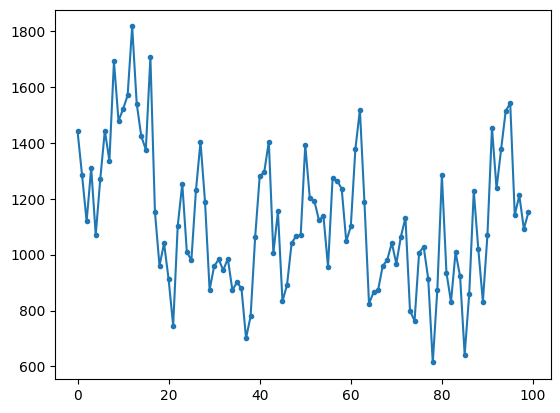

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5803a6fdd8>

In [32]:
figure()
plot(x_rx[1:100],".-")

## Continuous Sampling

In [6]:
N=20000 #Number of samples expected
for n in 1:10
    data = String[]
    i =1

    # Clear buffer
    while (bytesavailable(sp)>0)
        read(sp,UInt8)
    end

    # Start a conversion
    write(sp,"c")

    while bytesavailable(sp) < 1
        continue # wait for a response    
    end  
    sleep(0.001) # This extra delay helps with reliability - it gives the micro time to send all it needs to

    time = read(sp,String)
    print(time) 

    x_rx=zeros(Int16,N)

#     # Get the values
#     write(sp,"p") # Print DMA buffer
#     while bytesavailable(sp) < 1
#         continue # wait for a response    
#     end  

#     while true
#          if bytesavailable(sp) < 1
#             sleep(0.050) # Wait and check again
#             if bytesavailable(sp) < 1
#                 break
#             end
#         end
#         x_rx[i]=(parse(Int16,(readline(sp))))
#         i += 1
#     end
#     println("Number of bytes received ", i-1)
 
end

print("Done")

Conversion complete in 20000 us
Conversion complete in 20000 us
Conversion complete in 20001 us
Conversion complete in 20000 us
Conversion complete in 20000 us
Conversion complete in 20001 us
Conversion complete in 20000 us
Conversion complete in 20001 us
Conversion complete in 20000 us
Conversion complete in 20000 us
Done

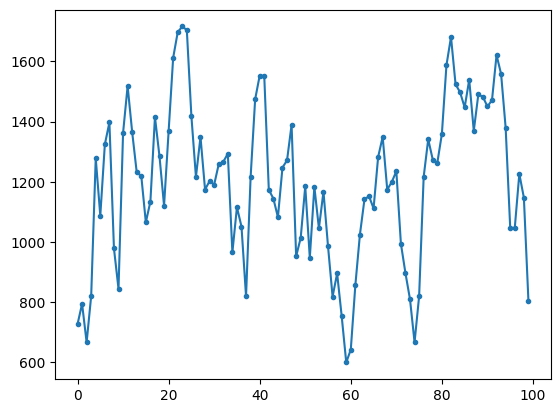

In [60]:
a= figure()
b = plot(x_rx[1:100],".-")  
show()